# **Money Authenticity Detection for Visual Impaired with CNN**

In [ ]:
# Sambungin ke google drive pribadi untuk akses dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
from io import BytesIO
from ipywidgets import widgets
from tensorflow.keras.utils import load_img, img_to_array
import json

In [2]:
print(tf.__version__)

2.17.1


## Dataset Exploration
```
.
│── Genuine Rupiah Banknotes/
│   ├── 1000/
│   │   ├── image_1.jpg
│   │   ├── image_2.jpg
│   │   └── ...
│   └── 2000/
│   │   ├── image_1.jpg
│   │   ├── image_2.jpg
│   │   └── ...
│   └── 5000/
│   │   ├── image_1.jpg
│   │   ├── image_2.jpg
│   │   └── ...
│   ├── 10000/
│   │   ├── image_1.jpg
│   │   ├── image_2.jpg
│   │   └── ...
│   └── 20000/
│   │   ├── image_1.jpg
│   │   ├── image_2.jpg
│   │   └── ...
│   └── 50000/
│   │   ├── image_1.jpg
│   │   ├── image_2.jpg
│   │   └── ...
│   └── 75000/
│   │   ├── image_1.jpg
│   │   ├── image_2.jpg
│   │   └── ...
│   └── 100000/
│       ├── image_1.jpg
│       ├── image_2.jpg
│       └── ...
└── Counterfeit Rupiah Banknotes/
    ├── 1000/
    │   ├── image_1.jpg
    │   ├── image_2.jpg
    │   └── ...
    └── 2000/
    │   ├── image_1.jpg
    │   ├── image_2.jpg
    │   └── ...
    └── 5000/
    │   ├── image_1.jpg
    │   ├── image_2.jpg
    │   └── ...
    ├── 10000/
    │   ├── image_1.jpg
    │   ├── image_2.jpg
    │   └── ...
    └── 20000/
    │   ├── image_1.jpg
    │   ├── image_2.jpg
    │   └── ...
    └── 50000/
    │   ├── image_1.jpg
    │   ├── image_2.jpg
    │   └── ...
    └── 75000/
    │   ├── image_1.jpg
    │   ├── image_2.jpg
    │   └── ...
    └── 100000/
        ├── image_1.jpg
        ├── image_2.jpg
        └── ...

```

In [ ]:
# Directory that holds the data
# DATA_DIR = r'/content/drive/MyDrive/Datasets' ## Kalau datasetnya dishortcut ke drive pribadi
DATA_DIR = r'/content/drive/MyDrive/[CAPSTONE] Bangkit: C242-PS279/Machine Learning Project/Project Ulhaq & Kresna: Deteksi Uang dengan CNN/Single Model/Datasets'

# Subdirectories for genuine and counterfeit banknotes
data_dir_genuine = os.path.join(DATA_DIR, 'Genuine Rupiah Banknotes')
data_dir_counterfeit = os.path.join(DATA_DIR, 'Counterfeit Rupiah Banknotes')

# Dictionary to hold subdirectories for each nominal value
nominal_values = ['1000', '2000', '5000', '10000', '20000', '50000', '75000', '100000']
data_counts = {'Nominal': [], 'Type': [], 'Count': []}

There are 224 genuine images of nominal 1000 Rupiah banknotes.
There are 33 counterfeit images of nominal 1000 Rupiah banknotes.
There are 115 genuine images of nominal 2000 Rupiah banknotes.
There are 42 counterfeit images of nominal 2000 Rupiah banknotes.
There are 267 genuine images of nominal 5000 Rupiah banknotes.
There are 38 counterfeit images of nominal 5000 Rupiah banknotes.
There are 243 genuine images of nominal 10000 Rupiah banknotes.
There are 37 counterfeit images of nominal 10000 Rupiah banknotes.
There are 254 genuine images of nominal 20000 Rupiah banknotes.
There are 37 counterfeit images of nominal 20000 Rupiah banknotes.
There are 211 genuine images of nominal 50000 Rupiah banknotes.
There are 45 counterfeit images of nominal 50000 Rupiah banknotes.
There are 9 genuine images of nominal 75000 Rupiah banknotes.
There are 23 counterfeit images of nominal 75000 Rupiah banknotes.
There are 267 genuine images of nominal 100000 Rupiah banknotes.
There are 51 counterfeit i

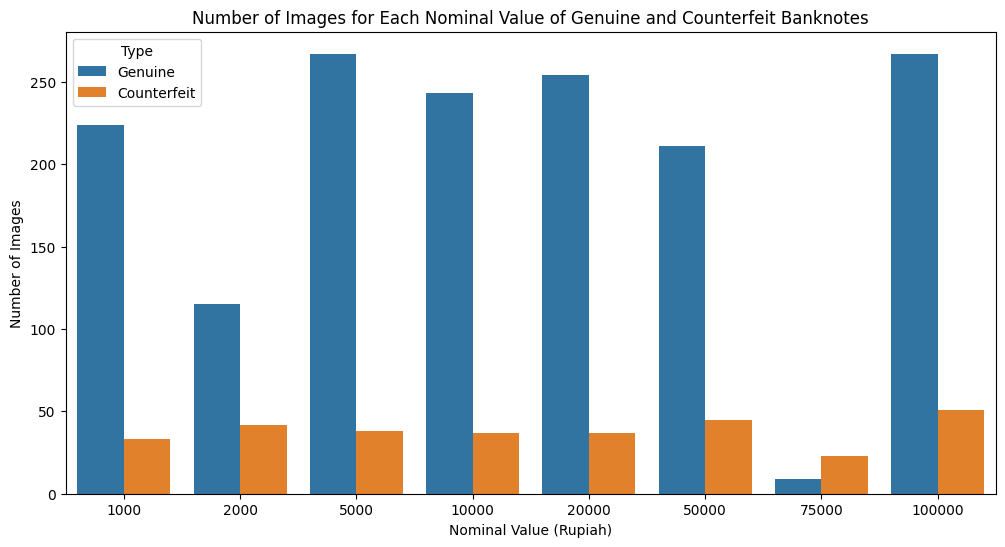

In [ ]:
# Display and collect the number of images for each nominal value in both genuine and counterfeit directories
for value in nominal_values:
    genuine_path = os.path.join(data_dir_genuine, value)
    counterfeit_path = os.path.join(data_dir_counterfeit, value)

    try:
        genuine_count = len(os.listdir(genuine_path))
        print(f'There are {genuine_count} genuine images of nominal {value} Rupiah banknotes.')
        data_counts['Nominal'].append(value)
        data_counts['Type'].append('Genuine')
        data_counts['Count'].append(genuine_count)
    except FileNotFoundError:
        print(f'Directory for genuine nominal {value} not found.')

    try:
        counterfeit_count = len(os.listdir(counterfeit_path))
        print(f'There are {counterfeit_count} counterfeit images of nominal {value} Rupiah banknotes.')
        data_counts['Nominal'].append(value)
        data_counts['Type'].append('Counterfeit')
        data_counts['Count'].append(counterfeit_count)
    except FileNotFoundError:
        print(f'Directory for counterfeit nominal {value} not found.')

# Convert the collected data into a DataFrame for plotting
df_counts = pd.DataFrame(data_counts)

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_counts, x='Nominal', y='Count', hue='Type')
plt.title('Number of Images for Each Nominal Value of Genuine and Counterfeit Banknotes')
plt.xlabel('Nominal Value (Rupiah)')
plt.ylabel('Number of Images')
plt.show()

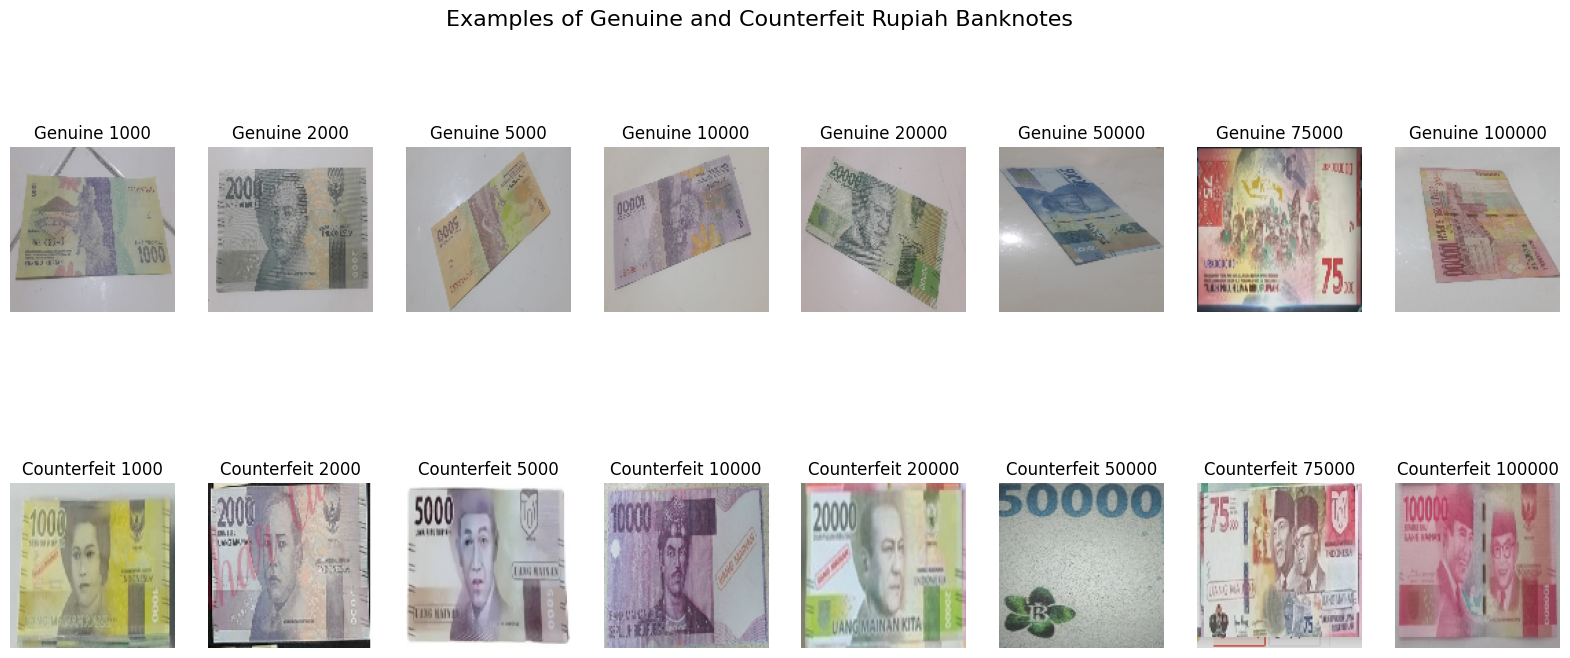

In [ ]:
# Display example images for each nominal value in both genuine and counterfeit categories
fig, axes = plt.subplots(2, len(nominal_values), figsize=(20, 8))
fig.suptitle('Examples of Genuine and Counterfeit Rupiah Banknotes', fontsize=16)

# Display genuine banknotes
for i, value in enumerate(nominal_values):
    genuine_path = os.path.join(data_dir_genuine, value)
    try:
        genuine_image = os.path.join(genuine_path, os.listdir(genuine_path)[0])
        img = tf.keras.utils.load_img(genuine_image, target_size=(120, 120))  # Resize if needed
        axes[0, i].imshow(img)
        axes[0, i].set_title(f'Genuine {value}')
        axes[0, i].axis('off')
    except (FileNotFoundError, IndexError):
        axes[0, i].text(0.5, 0.5, 'Not found', ha='center', va='center')
        axes[0, i].set_title(f'Genuine {value}')
        axes[0, i].axis('off')

# Display counterfeit banknotes
for i, value in enumerate(nominal_values):
    counterfeit_path = os.path.join(data_dir_counterfeit, value)
    try:
        counterfeit_image = os.path.join(counterfeit_path, os.listdir(counterfeit_path)[0])
        img = tf.keras.utils.load_img(counterfeit_image, target_size=(120, 120))  # Resize if needed
        axes[1, i].imshow(img)
        axes[1, i].set_title(f'Counterfeit {value}')
        axes[1, i].axis('off')
    except (FileNotFoundError, IndexError):
        axes[1, i].text(0.5, 0.5, 'Not found', ha='center', va='center')
        axes[1, i].set_title(f'Counterfeit {value}')
        axes[1, i].axis('off')

plt.show()

## Dataset Preprocessing

In [ ]:
# Preprocess dataset for multi-output classification
def prepare_datasets():
    # Define labels for each nominal value
    label_map = {nominal: idx for idx, nominal in enumerate(nominal_values)}

    # Load datasets with labels for both 'authenticity' and 'nominal'
    def preprocess_image(file_path, label):
        img = tf.keras.utils.load_img(file_path, target_size=(120, 120))
        img = tf.keras.utils.img_to_array(img)
        img = img / 255.0
        return img, label

    images = []
    authenticity_labels = []
    nominal_labels = []

    # Process genuine notes
    for nominal in nominal_values:
        genuine_path = os.path.join(data_dir_genuine, nominal)
        if os.path.exists(genuine_path):
            for file in os.listdir(genuine_path):
                file_path = os.path.join(genuine_path, file)
                img, _ = preprocess_image(file_path, None)
                images.append(img)
                authenticity_labels.append(1)  # Genuine
                nominal_labels.append(label_map[nominal])

    # Process counterfeit notes
    for nominal in nominal_values:
        counterfeit_path = os.path.join(data_dir_counterfeit, nominal)
        if os.path.exists(counterfeit_path):
            for file in os.listdir(counterfeit_path):
                file_path = os.path.join(counterfeit_path, file)
                img, _ = preprocess_image(file_path, None)
                images.append(img)
                authenticity_labels.append(0)  # Counterfeit
                nominal_labels.append(label_map[nominal])

    # Convert to NumPy arrays
    images = np.array(images)
    authenticity_labels = np.array(authenticity_labels)
    nominal_labels = np.array(nominal_labels)

    # Split into training, validation, and test datasets
    X_temp, X_test, y_auth_temp, y_auth_test, y_nom_temp, y_nom_test = train_test_split(
        images, authenticity_labels, nominal_labels, test_size=0.2, random_state=42
    )
    X_train, X_val, y_auth_train, y_auth_val, y_nom_train, y_nom_val = train_test_split(
        X_temp, y_auth_temp, y_nom_temp, test_size=0.1875, random_state=42
    )  # 15% of the total for validation

    return (X_train, [y_auth_train, y_nom_train]), (X_val, [y_auth_val, y_nom_val]), (X_test, [y_auth_test, y_nom_test])

In [ ]:
# Prepare datasets
train_data, val_data, test_data = prepare_datasets()

In [ ]:
 # Unpack training and validation data
X_train, [y_auth_train, y_nom_train] = train_data
X_val, [y_auth_val, y_nom_val] = val_data

 # Take the first batch of training data
example_batch_images = X_train[:10]
example_batch_authenticity_labels = y_auth_train[:10]
example_batch_nominal_labels = y_nom_train[:10]

# Print batch information
print(f'Maximum pixel value of images: {np.max(example_batch_images)}')
print(f'Shape of batch of images: {example_batch_images.shape}')
print(f'Shape of batch of authenticity labels: {example_batch_authenticity_labels.shape}')
print(f'Shape of batch of nominal labels: {example_batch_nominal_labels.shape}')

Maximum pixel value of images: 1.0
Shape of batch of images: (10, 120, 120, 3)
Shape of batch of authenticity labels: (10,)
Shape of batch of nominal labels: (10,)


## Create Model

In [ ]:
def create_multi_output_model():
    inputs = tf.keras.Input(shape=(120, 120, 3))

    # Common feature extractor
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001))(inputs)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001))(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001))(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.001))(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    # Output for authenticity classification
    authenticity_output = tf.keras.layers.Dense(1, activation='sigmoid', name='authenticity', kernel_regularizer=l2(0.001))(x)

    # Increased capacity for nominal classification
    nominal_dense = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x)
    nominal_dense = tf.keras.layers.Dropout(0.5)(nominal_dense)

    # Output for nominal classification
    nominal_output = tf.keras.layers.Dense(len(nominal_values), activation='softmax', name='nominal', kernel_regularizer=l2(0.001))(x)

    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=[authenticity_output, nominal_output])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss={
            'authenticity': 'binary_crossentropy',
            'nominal': 'sparse_categorical_crossentropy',
        },
        metrics={
            'authenticity': 'accuracy',
            'nominal': 'accuracy',
        }
    )

    return model

In [ ]:
# Create and compile the model
multi_output_model = create_multi_output_model()

In [ ]:
multi_output_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 120, 120, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 118, 118, 32)   │            896 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 59, 59, 32)     │              0 │ conv2d_4[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 57, 57, 64)     │         18,496 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 28, 28, 64)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 26, 26, 128)    │         73,856 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 13, 13, 128)    │              0 │ conv2d_6[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 11, 11, 256)    │        295,168 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 5, 5, 256)      │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 6400)           │              0 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 6400)           │              0 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ authenticity (Dense)      │ (None, 1)              │          6,401 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ nominal (Dense)           │ (None, 8)              │         51,208 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 446,025 (1.70 MB)

 Trainable params: 446,025 (1.70 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Model evaluation for compatibility
try:
    multi_output_model.evaluate(val_data[0], val_data[1], verbose=False)
except ValueError as e:
    print(f'Model evaluation error: {e}')
    print('The model is not compatible with the dataset you defined earlier. Check that the loss function, last layer and label_mode are compatible with one another.')
else:
    print('The model work well with the datasets.')

The model work well with the datasets.


In [ ]:
# Train the model
history = multi_output_model.fit(
    train_data[0], train_data[1],
    epochs=20,
    batch_size=32,
    validation_data=(val_data[0], val_data[1])
)

Epoch 1/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - authenticity_accuracy: 0.8425 - authenticity_loss: 0.4581 - loss: 2.7321 - nominal_accuracy: 0.1575 - nominal_loss: 2.0181 - val_authenticity_accuracy: 0.8246 - val_authenticity_loss: 0.4374 - val_loss: 2.4293 - val_nominal_accuracy: 0.2842 - val_nominal_loss: 1.8535
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - authenticity_accuracy: 0.8295 - authenticity_loss: 0.4472 - loss: 2.2618 - nominal_accuracy: 0.3094 - nominal_loss: 1.6817 - val_authenticity_accuracy: 0.8246 - val_authenticity_loss: 0.4308 - val_loss: 1.9484 - val_nominal_accuracy: 0.4070 - val_nominal_loss: 1.4072
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - authenticity_accuracy: 0.8244 - authenticity_loss: 0.4215 - loss: 1.8729 - nominal_accuracy: 0.5091 - nominal_loss: 1.3401 - val_authenticity_accuracy: 0.8281 - val_authenticity_loss: 0.4852 - val_loss: 1.6821 - val_nominal_accuracy: 0.5719 - val_nominal_loss: 1.0959
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 77

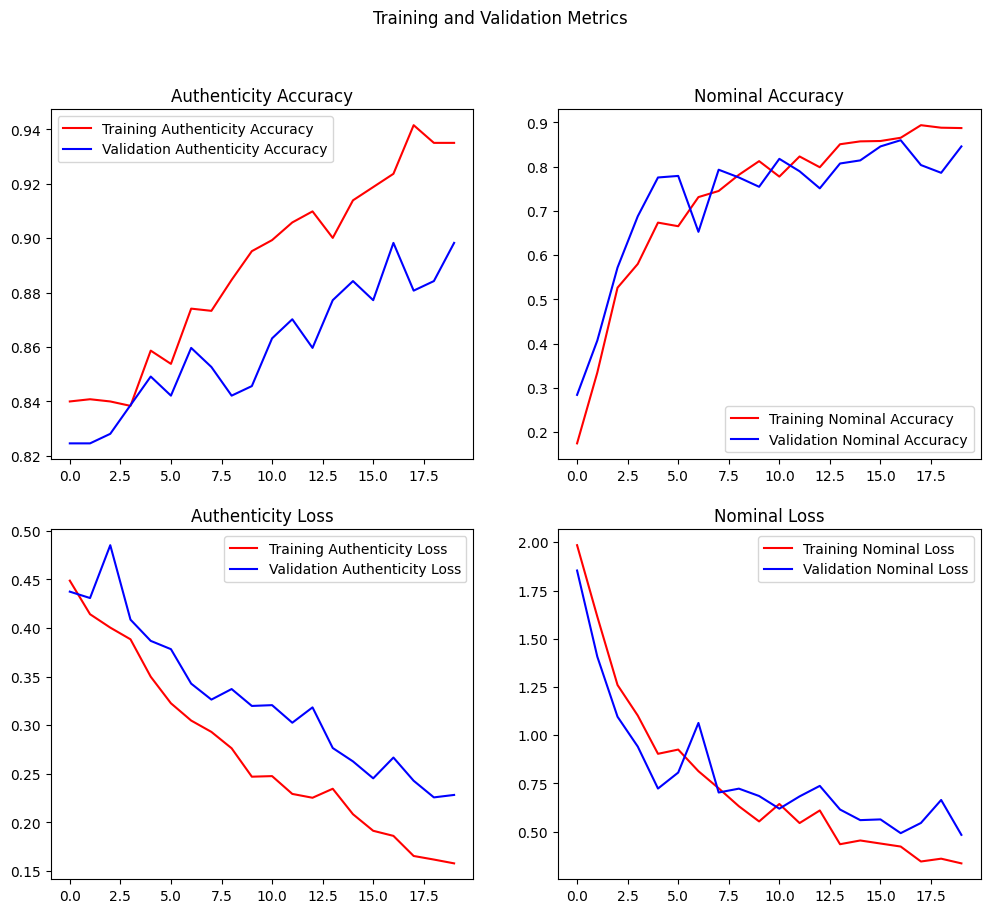

In [ ]:
auth_acc = history.history['authenticity_accuracy']
auth_val_acc = history.history['val_authenticity_accuracy']
nom_acc = history.history['nominal_accuracy']
nom_val_acc = history.history['val_nominal_accuracy']

auth_loss = history.history['authenticity_loss']
auth_val_loss = history.history['val_authenticity_loss']
nom_loss = history.history['nominal_loss']
nom_val_loss = history.history['val_nominal_loss']

epochs = range(len(auth_acc))

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Training and Validation Metrics')

# Plot authenticity accuracy
axs[0, 0].plot(epochs, auth_acc, 'r', label='Training Authenticity Accuracy')
axs[0, 0].plot(epochs, auth_val_acc, 'b', label='Validation Authenticity Accuracy')
axs[0, 0].set_title('Authenticity Accuracy')
axs[0, 0].legend()

# Plot nominal accuracy
axs[0, 1].plot(epochs, nom_acc, 'r', label='Training Nominal Accuracy')
axs[0, 1].plot(epochs, nom_val_acc, 'b', label='Validation Nominal Accuracy')
axs[0, 1].set_title('Nominal Accuracy')
axs[0, 1].legend()

# Plot authenticity loss
axs[1, 0].plot(epochs, auth_loss, 'r', label='Training Authenticity Loss')
axs[1, 0].plot(epochs, auth_val_loss, 'b', label='Validation Authenticity Loss')
axs[1, 0].set_title('Authenticity Loss')
axs[1, 0].legend()

# Plot nominal loss
axs[1, 1].plot(epochs, nom_loss, 'r', label='Training Nominal Loss')
axs[1, 1].plot(epochs, nom_val_loss, 'b', label='Validation Nominal Loss')
axs[1, 1].set_title('Nominal Loss')
axs[1, 1].legend()

plt.show()

## Testing Model

In [ ]:
results = multi_output_model.evaluate(
    x=test_data[0],
    y={'authenticity': test_data[1][0], 'nominal': test_data[1][1]},
    verbose=1
)

# Print evaluation results
print(f'Total Test Loss: {results[0]}')
print(f'Authenticity Test Loss: {results[1]}')
print(f'Nominal Test Loss: {results[2]}')
print(f'Authenticity Test Accuracy: {results[3]}')
print(f'Nominal Test Accuracy: {results[4]}')

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 403ms/step - authenticity_accuracy: 0.9303 - authenticity_loss: 0.1552 - loss: 0.8117 - nominal_accuracy: 0.8568 - nominal_loss: 0.5155
Total Test Loss: 0.8708171844482422
Authenticity Test Loss: 0.18262135982513428
Nominal Test Loss: 0.5464429259300232
Authenticity Test Accuracy: 0.9210526347160339
Nominal Test Accuracy: 0.8421052694320679


## Model Application

### Test with single file from directory

In [ ]:
# Function to predict authenticity and nominal
def predict_image(file_path):
    # Load and preprocess the image to match model's input size (120, 120)
    image = load_img(file_path, target_size=(120, 120))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)  # Add batch dimension

    # Multi-output prediction
    authenticity_pred, nominal_pred = multi_output_model.predict(image, verbose=0)

    # Convert authenticity prediction to human-readable format
    authenticity = 'Genuine' if authenticity_pred[0] > 0.5 else 'Counterfeit'

    # Get nominal class prediction and map it to nominal value
    nominal = nominal_values[np.argmax(nominal_pred)]  # Map to nominal value

    return authenticity, nominal

# Path to the image file you want to predict
# file_path = r'/content/drive/MyDrive/Data Example (buat eksperimen)/Uang Fake/Uang Fake 5000.jpg' # Kalau datasetnya dishortcut ke drive pribadi
file_path = r'/content/drive/MyDrive/[CAPSTONE] Bangkit: C242-PS279/Machine Learning Project/Project Ulhaq & Kresna: Deteksi Uang dengan CNN/Data Example (buat eksperimen)/Uang Fake/Uang Fake 20000.jpg'

# Call the function with the file path
authenticity, nominal = predict_image(file_path)

# Print the result
print(f'File: {file_path}')
print(f'Authenticity: {authenticity}')
print(f'Nominal: Rp{nominal}')

File: /content/drive/MyDrive/[CAPSTONE] Bangkit: C242-PS279/Machine Learning Project/Project Ulhaq & Kresna: Deteksi Uang dengan CNN/Data Example (buat eksperimen)/Uang Fake/Uang Fake 20000.jpg
Authenticity: Counterfeit
Nominal: Rp1000


### Test with all file in directory

In [ ]:
# Directory path containing test images
# test_dir = r'/content/drive/MyDrive/Data Example (buat eksperimen)/Uang Fake' # Kalau datasetnya dishortcut ke drive pribadi
test_dir = r'/content/drive/MyDrive/[CAPSTONE] Bangkit: C242-PS279/Machine Learning Project/Project Ulhaq & Kresna: Deteksi Uang dengan CNN/Data Example (buat eksperimen)/Uang Fake'

# Function to predict authenticity and nominal
def predict_image_from_path(file_path):
    # Load and preprocess the image to match model's input size (120, 120)
    image = load_img(file_path, target_size=(120, 120))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)  # Add batch dimension

    # Multi-output prediction
    authenticity_pred, nominal_pred = multi_output_model.predict(image, verbose=0)

    # Convert authenticity prediction to human-readable format
    authenticity = 'Genuine' if authenticity_pred[0] > 0.5 else 'Counterfeit'

    # Get nominal class prediction and map it to nominal value
    nominal = nominal_values[np.argmax(nominal_pred)]  # Map to nominal value

    return authenticity, nominal

# Loop through images in directory
for file_name in os.listdir(test_dir):
    file_path = os.path.join(test_dir, file_name)
    if file_name.lower().endswith(('.jpg', '.jpeg', '.png')):  # Validate file type
        authenticity, nominal = predict_image_from_path(file_path)
        print(f"{file_name}: {authenticity}, Nominal: Rp{nominal}")


Uang Fake 1000.png: Counterfeit, Nominal: Rp1000
Uang Fake 100000.jpg: Genuine, Nominal: Rp100000
Uang Fake 75000.jpg: Genuine, Nominal: Rp75000
Uang Fake 20000.jpg: Counterfeit, Nominal: Rp1000
Uang Fake 10000.jpg: Counterfeit, Nominal: Rp10000
Uang Fake 5000.jpg: Genuine, Nominal: Rp5000
Uang Fake 2000.jpg: Counterfeit, Nominal: Rp10000
Uang Fake 50000.jpg: Counterfeit, Nominal: Rp5000


### Test with choosing file

In [ ]:
# File uploader widget
uploader = widgets.FileUpload(accept='image/*', multiple=True)
display(uploader)

# Output widget
out = widgets.Output()
display(out)

# Function to predict file authenticity and nominal
def file_predict(filename, file, out):
    # Resize the image to fit the model input
    image = tf.keras.utils.load_img(file, target_size=(120, 120))
    image = tf.keras.utils.img_to_array(image)
    image = np.expand_dims(image, axis=0)

    # Predict using model
    prediction = multi_output_model.predict(image, verbose=0)

    # Take the result for both authenticity and nominal
    authenticity_prediction = prediction[0][0]
    nominal_prediction = prediction[1]

    with out:
        # Result for authenticity
        if authenticity_prediction > 0.5:
            print(f'{filename} is a genuine rupiah banknote')
        else:
            print(f'{filename} is a counterfeit rupiah banknote')

        # Result for nominal
        predicted_nominal = np.argmax(nominal_prediction)
        print(f'Predicted nominal: {nominal_values[predicted_nominal]}')

# Function to handle file uploads
def on_upload_change(change):
    # Clear output before displaying new results
    out.clear_output()

    # Iterate over uploaded files
    for filename, file_info in uploader.value.items():
        file_content = file_info['content']
        file_bytes = BytesIO(file_content)
        file_predict(filename, file_bytes, out)

# Observe uploader for changes
uploader.observe(on_upload_change, names='value')

FileUpload(value={}, accept='image/*', description='Upload', multiple=True)

Output()

## Convert Model

### Convert to Keras

In [ ]:
# Save the trained model as a Keras file

saved_model_path_keras = r'/content/drive/MyDrive/[CAPSTONE] Bangkit: C242-PS279/Machine Learning Project/Project Ulhaq & Kresna: Deteksi Uang dengan CNN/Single Model/Convert Model Result/Money-Authenticity-Detection_Model.keras'

multi_output_model.save(saved_model_path_keras)

print(f'Model with H5 format successfully saved in {saved_model_path_keras}')

Model with H5 format successfully saved in /content/drive/MyDrive/[CAPSTONE] Bangkit: C242-PS279/Machine Learning Project/Project Ulhaq & Kresna: Deteksi Uang dengan CNN/Single Model/Convert Model Result/Money-Authenticity-Detection_Model.keras


### Convert to H5

In [ ]:
# Save the trained model as a Keras HDF5 file

saved_model_path_h5 = r'/content/drive/MyDrive/[CAPSTONE] Bangkit: C242-PS279/Machine Learning Project/Project Ulhaq & Kresna: Deteksi Uang dengan CNN/Single Model/Convert Model Result/Money-Authenticity-Detection_Model.h5'

multi_output_model.save(saved_model_path_h5)

print(f'Model with H5 format successfully saved in {saved_model_path_h5}')

Model with H5 format successfully saved in /content/drive/MyDrive/[CAPSTONE] Bangkit: C242-PS279/Machine Learning Project/Project Ulhaq & Kresna: Deteksi Uang dengan CNN/Single Model/Convert Model Result/Money-Authenticity-Detection_Model.h5


### Convert to JSON

In [ ]:
# Get the model configuration in JSON format
model_json = multi_output_model.to_json()

# Save the model configuration to a .json file
json_file_path = '/content/drive/MyDrive/[CAPSTONE] Bangkit: C242-PS279/Machine Learning Project/Project Ulhaq & Kresna: Deteksi Uang dengan CNN/Single Model/Convert Model Result/Money-Authenticity-Detection_Model.json'
with open(json_file_path, 'w') as json_file:
    json.dump(model_json, json_file)

print(f'Model successfully converted to JSON and saved at {json_file_path}')

Model successfully converted to JSON and saved at /content/drive/MyDrive/[CAPSTONE] Bangkit: C242-PS279/Machine Learning Project/Project Ulhaq & Kresna: Deteksi Uang dengan CNN/Single Model/Convert Model Result/Money-Authenticity-Detection_Model.json
